# Part I: Profiling expression STRs across 17 human tissues

This notebook contains:

#### Figures:
* **Figure 1B**: QQ plot for eSTR linear regression statistics
* **Figure 1C**: Correlation of effect sizes across tissues
* **Figure 1C inset**: Comparison to NG effect sizes

#### Supplementary Figures:
* **Supplementary Figure TISSUESHARING**: Number of eSTRs shared across tissues

#### Tables:
* **Table 1**: Number of samples, eSTRs, causal eSTRs per tissue

#### Supplementary Tables:
* **Supplementary Table ALLCAUSAL**: All causal examples across tissues

#### Statistics:
* Average number of genes tested per tissue
* Average number of STR by gene tests per tissue
* Number of unique eSTRs and eGenes
* Correlation of effect sizes with LCL and % showing same direction
* How many eSTRs improved model over best SNP ANOVA
* How many eSTRs had highest CAVIAR scores
* Number of total causal eSTRs

Additionally, these notebooks contain other results presented in part I:
* **eSTRLiteratureExamples.ipynb**: **Supplementary Table LITERATURE**, **Figure 1D**
* **eSTRPreprocessing.ipynb**: **Supplementary Figure POPPCA**, **Supplementary Figure PEER**, how many STRs in all analyses, and population breakdown of the GTEx cohort

In [1]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-calling"
FIGPREFIX = "Figure1"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Tissue info ##############
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

SHORTEN = {
    "Artery-Aorta":"Artery A."     ,
    "Artery-Tibial": "Artery T.",
    "Adipose-Subcutaneous": "Adipose S.",    
    "Adipose-Visceral":"Adipose V.",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "E. Mucosa",
    "Esophagus-Muscularis":"E Muscularis",
    "Heart-LeftVentricle":"Ventricle",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "Skin Unexposed",
    "Skin-SunExposed":"Skin Leg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood",
    "permuted":"Permuted",
    "LCL": "LCL"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

MINANOVAQ = 0.1 # 10% FDR for ANOVA analysis
MINANOVAP = 0.05 # nominal p-value for ANOVA analysis

############ Load data ################
NGESTR = pd.read_csv(os.path.join(DATADIR, "2016_estrs_table.csv"))

# Linear regression data
data = {} # Map of tissue -> data
for t in TISSUES:
    data[t] = pd.read_csv(os.path.join(DATADIR, "%s_LinearRegression.tab"%t), sep="\t", usecols=[0,1,3,8,11])
    # Reformat gene names and start coords
    data[t]["gene"] = data[t]["gene"].apply(lambda x: x.split(".")[0])
    data[t]["str.start"] = (data[t]["str.start"] + 1).apply(int)
data["permuted"] = pd.read_csv(os.path.join(DATADIR, "WholeBlood_LinearRegression_permuted.tab"), sep="\t")
data["LCL"] = NGESTR

master = {} # Map of tissue -> master data. Include all loci for comparisons below
for t in TISSUES:
    df = pd.read_csv(os.path.join(DATADIR, "%s_MasterTable.tab"%t), sep="\t")
    df = df[~np.isnan(df["best.str.start"])]
    df["str.start"] = (df["best.str.start"] + 1).apply(int)
    df["gene"] = df["gene"].apply(lambda x: x.split(".")[0])
    df = pd.merge(df, data[t], on=["str.start","gene","beta"], how="outer")
    df["significant"] = (df["significant"]==1)
    df["signif_%s"%t] = df["significant"]
    master[t] = df
master["LCL"] = NGESTR
master["LCL"]["str.id"] = master["LCL"]["str.start"].apply(lambda x: "STR_%s"%(x-1))
master["LCL"]["significant"] = master["LCL"]["signif.estr"]

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Functions
def concat(x):
    return ";".join([str(item) for item in x])

# Figure 1B: QQ Plot

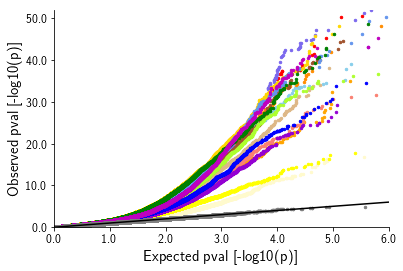

In [87]:
TISSUES = sorted(TISSUES)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
maxval = 0
for t in TISSUES + ["permuted"]:
    unif = sorted(list(np.random.uniform(low=0, high=1, size=data[t].shape[0])))
    unif_log = [-1*np.log10(x) for x in unif]
    pvals = sorted(list(data[t]["p.wald"]))
    pvals_log = [-1*np.log10(x) for x in pvals]
    maxval = max([maxval]+pvals_log)
    ax.scatter(unif_log, pvals_log, color=COLORS[t], label=SHORTEN[t], s=6)
ax.plot([0,6],[0,6], color="black")
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot.png"%FIGPREFIX))

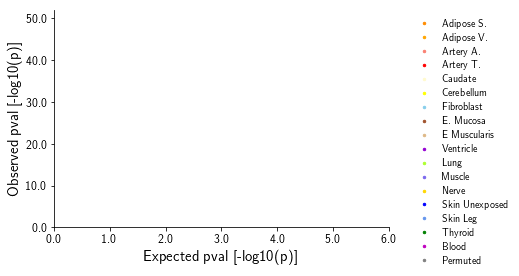

In [88]:
# Additionally plot the skeleton as pdf to use in Illustrator
fig = plt.figure()
ax = fig.add_subplot(111)
for t in TISSUES + ["permuted"]:
    ax.scatter([],[], color=COLORS[t], label=SHORTEN[t], s=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=0, right=6)
ax.set_ylim(bottom=0, top=maxval/5*5)
ax.set_xlabel("Expected pval [-log10(p)]", size=15)
ax.set_ylabel("Observed pval [-log10(p)]", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, frameon=False);
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_qqplot_skeleton.pdf"%FIGPREFIX))

In [15]:
%%bash -s "$DATADIR"

DATADIR=$1
TISSUES="Adipose-Subcutaneous Adipose-Visceral Artery-Aorta Artery-Tibial Brain-Caudate Brain-Cerebellum \
    Cells-Transformedfibroblasts Esophagus-Mucosa Esophagus-Muscularis Heart-LeftVentricle Lung \
    Muscle-Skeletal Nerve-Tibial Skin-NotSunExposed Skin-SunExposed Thyroid WholeBlood"

# Number of genes tested per tissue
for t in $TISSUES
do
    echo $(cat ${DATADIR}/${t}_LinearRegression.tab | cut -f 1 | uniq | wc -l)
done | datamash mean 1

# Number of STR by gene tests
for t in $TISSUES
do
    echo $(cat ${DATADIR}/${t}_LinearRegression.tab | grep -v gene | wc -l)
done | datamash mean 1

16064.941176471
278521.05882353


# Table 1: eSTR summary

In [28]:
# Number of eSTRs per tissue, number total eSTRs, number genes

chroms = []
starts = []
genes = []

for t in TISSUES:
    d = master[t]
    estrs = d[(d["best.str"]==1) & (d["qvalue"]<=MINQ)]
    print("%s: %s eSTRs"%(t, estrs.shape[0]))
    chroms.extend(list(estrs["chrom_x"]))
    starts.extend(list(estrs["str.start"]))
    genes.extend(list(estrs["gene"]))
    
# Number of unique eSTRs
allestrs = pd.DataFrame({"chrom_x": chroms, "str.start": starts, "gene": genes}).drop_duplicates()
print("Number unique eSTRs: %s"%(allestrs[["chrom_x","str.start","gene"]].shape[0]))
print("Number unique genes: %s"%(len(set(allestrs["gene"]))))

Skin-SunExposed: 3827 eSTRs
Artery-Tibial: 3454 eSTRs
Brain-Caudate: 675 eSTRs
Lung: 2989 eSTRs
Nerve-Tibial: 4352 eSTRs
Cells-Transformedfibroblasts: 3088 eSTRs
Muscle-Skeletal: 3370 eSTRs
WholeBlood: 2585 eSTRs
Adipose-Visceral: 1840 eSTRs
Artery-Aorta: 2396 eSTRs
Heart-LeftVentricle: 1731 eSTRs
Adipose-Subcutaneous: 3587 eSTRs
Esophagus-Mucosa: 3461 eSTRs
Esophagus-Muscularis: 2824 eSTRs
Skin-NotSunExposed: 2386 eSTRs
Brain-Cerebellum: 1551 eSTRs
Thyroid: 4105 eSTRs
Number unique eSTRs: 25561
Number unique genes: 11810


In [7]:
%%bash

TISSUES="Adipose-Subcutaneous Adipose-Visceral Artery-Aorta Artery-Tibial Brain-Caudate Brain-Cerebellum \
    Cells-Transformedfibroblasts Esophagus-Mucosa Esophagus-Muscularis Heart-LeftVentricle Lung \
    Muscle-Skeletal Nerve-Tibial Skin-NotSunExposed Skin-SunExposed Thyroid WholeBlood"

for t in $TISSUES
do
    # Number of samples per tissue
    numsamples=$(cat /storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv | grep -v ENSG | wc -l)
    echo $t $numsamples
done

Adipose-Subcutaneous 270
Adipose-Visceral 193
Artery-Aorta 191
Artery-Tibial 276
Brain-Caudate 108
Brain-Cerebellum 107
Cells-Transformedfibroblasts 225
Esophagus-Mucosa 255
Esophagus-Muscularis 214
Heart-LeftVentricle 199
Liver 102
Lung 259
Muscle-Skeletal 343
Nerve-Tibial 265
Skin-NotSunExposed 209
Skin-SunExposed 297
Thyroid 262
WholeBlood 336


# Supplementary Figure TISSUESHARING

In [ ]:
# For each eSTR, count number of tissues
alldata = allestrs
alldata["num.tissues"] = 0

for t in TISSUES:
    x = master[t]
    x = x[x["signif_%s"%t]]
    alldata = pd.merge(alldata, x[["chrom_x","str.start","gene","signif_%s"%t]], \
                   on=["chrom_x","gene","str.start"], how="left")
    alldata = alldata.fillna({'signif_%s'%t: False})
    alldata["num.tissues"] = alldata["num.tissues"]+alldata["signif_%s"%t]
    alldata = alldata.drop("signif_%s"%t, 1)

alldata = alldata[alldata["num.tissues"]>0]

In [41]:
counts = []
for i in range(1, 11):
    if i == 10:
        counts.append(alldata[alldata["num.tissues"]>=i].shape[0])
    else: counts.append(alldata[alldata["num.tissues"]==i].shape[0])

shared across 2 or more tissues: 8417
shared across 2 or more tissues (percent): 0.3254582012218699
shared across 10 or more tissues: 469


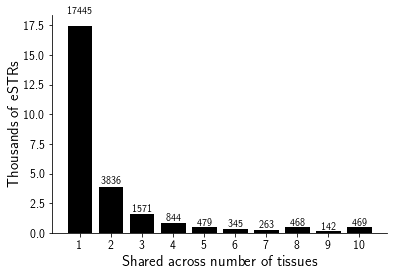

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

countsbar = ax.bar(range(1, 11), counts, color="black")
ax.set_xticks(range(1, 11))
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax.set_yticklabels([int(x)/1000 for x in ax.get_yticks()], size=12);
ax.set_xlabel("Shared across number of tissues", size=15)
ax.set_ylabel("Thousands of eSTRs", size=15);

# Add text
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(countsbar)
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR,"SuppFig_TISSUESHARING.pdf"))
    
print("shared across 2 or more tissues: %s"%alldata[alldata["num.tissues"]>=2].shape[0])
print("shared across 2 or more tissues (percent): %s"%(alldata[alldata["num.tissues"]>=2].shape[0]*1.0/alldata.shape[0]))
print("shared across 10 or more tissues: %s"%alldata[alldata["num.tissues"]>=10].shape[0])

# Figure 1C: Effect size correlation

In [9]:
ALLTISSUES = [
    'Brain-Caudate',
    'Brain-Cerebellum',
         'Muscle-Skeletal',
    'Cells-Transformedfibroblasts',
     'Esophagus-Mucosa',
     'Skin-NotSunExposed',
     'Skin-SunExposed',
     'Esophagus-Muscularis',
    'Artery-Aorta',
    'Artery-Tibial',
    'Adipose-Subcutaneous',
    'Adipose-Visceral',
     'Lung',
     'Thyroid',
     'Nerve-Tibial',
     'Heart-LeftVentricle',
     'WholeBlood',
]
ALLTISSUES = ALLTISSUES[::-1]

In [6]:
t1 = "LCL"
prs = []
dirs = []

for j in range(len(ALLTISSUES)):
    t2 = ALLTISSUES[j]
    if t2 == "LCL": continue
    d = pd.merge(master[t1][["str.id","gene","beta","significant"]], \
                     master[t2][["str.id","gene","beta","significant"]], on=["str.id","gene"])
    d = d[(d["significant_x"]) | (d["significant_y"])]
    x = scipy.stats.pearsonr(d["beta_x"], d["beta_y"])
    dsame = np.mean(np.sign(d["beta_x"])==np.sign(d["beta_y"]))
    print("%s %s %s %s"%(t1, t2, x, dsame))
    prs.append(x[0])
    dirs.append(dsame)
print("Average pearson r with LCL: %s"%np.mean(prs))
print("Percent same direction: %s"%np.mean(dirs))

LCL Brain-Caudate (0.5853775675213823, 2.4912957284056583e-37) 0.7774936061381074
LCL Brain-Cerebellum (0.43530221055298585, 8.11071454254583e-43) 0.6893095768374164
LCL Muscle-Skeletal (0.5083043763223121, 2.2083458000324858e-119) 0.7184734513274337
LCL Cells-Transformedfibroblasts (0.6051198474243171, 7.652476834048366e-171) 0.7777126099706745
LCL Esophagus-Mucosa (0.5802965653458272, 1.592629417642083e-167) 0.7526939655172413
LCL Skin-NotSunExposed (0.5596344130795076, 1.6322181649807422e-108) 0.7480857580398163
LCL Skin-SunExposed (0.5133696062298776, 3.0825591361714705e-137) 0.7164619164619165
LCL Esophagus-Muscularis (0.5902478663796158, 5.583679337954028e-146) 0.7648578811369509
LCL Artery-Aorta (0.5790588253710417, 3.9451845365651727e-119) 0.7577592732778198
LCL Artery-Tibial (0.5402926655989002, 1.5408448352310423e-141) 0.738850080601827
LCL Adipose-Subcutaneous (0.5643775573217243, 1.0888416779136589e-164) 0.7434715821812596
LCL Adipose-Visceral (0.6292633277540474, 5.7055233

In [10]:
pdata = np.zeros((len(ALLTISSUES), len(ALLTISSUES)))
for i in range(len(ALLTISSUES)):
    for j in range(i+1):
        t1 = ALLTISSUES[i]
        t2 = ALLTISSUES[j]
        d = pd.merge(master[t1][["str.id","gene","beta","significant"]], \
                     master[t2][["str.id","gene","beta","significant"]], on=["str.id","gene"])
        d = d[(d["significant_x"]) | (d["significant_y"])]
        pdata[i][j] = scipy.stats.pearsonr(d["beta_x"], d["beta_y"])[0]
        pdata[j][i] = scipy.stats.pearsonr(d["beta_x"], d["beta_y"])[0]
        print("%s %s %s"%(t1, t2, scipy.stats.pearsonr(d["beta_x"], d["beta_y"])))

WholeBlood WholeBlood (1.0, 0.0)
Heart-LeftVentricle WholeBlood (0.7586531441899401, 1.044493372963516e-201)
Heart-LeftVentricle Heart-LeftVentricle (1.0, 0.0)
Nerve-Tibial WholeBlood (0.7578847032814994, 0.0)
Nerve-Tibial Heart-LeftVentricle (0.869336441370143, 0.0)
Nerve-Tibial Nerve-Tibial (1.0, 0.0)
Thyroid WholeBlood (0.7232459602427831, 0.0)
Thyroid Heart-LeftVentricle (0.8569014994224614, 0.0)
Thyroid Nerve-Tibial (0.865117358359814, 0.0)
Thyroid Thyroid (1.0, 0.0)
Lung WholeBlood (0.8494307257324419, 0.0)
Lung Heart-LeftVentricle (0.8762089529170637, 0.0)
Lung Nerve-Tibial (0.9034703273344131, 0.0)
Lung Thyroid (0.8971095031449641, 0.0)
Lung Lung (1.0, 0.0)
Adipose-Visceral WholeBlood (0.8452582423376105, 0.0)
Adipose-Visceral Heart-LeftVentricle (0.9256949486935879, 0.0)
Adipose-Visceral Nerve-Tibial (0.9274002874416697, 0.0)
Adipose-Visceral Thyroid (0.9059068086248869, 0.0)
Adipose-Visceral Lung (0.9430011979108697, 0.0)
Adipose-Visceral Adipose-Visceral (1.0, 0.0)
Adipose-S

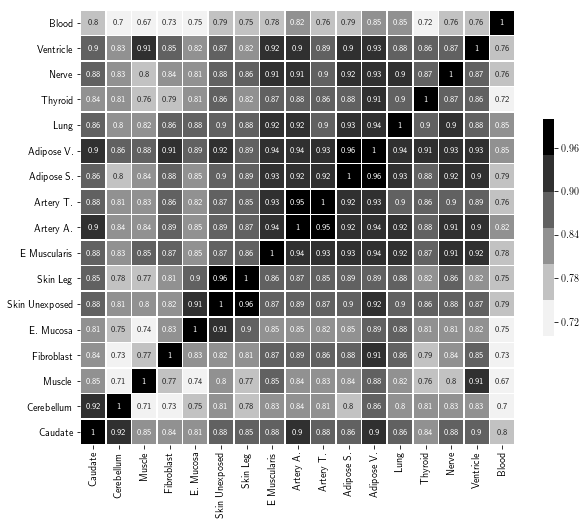

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.light_palette("black") #sns.diverging_palette(265, 15, s=80, l=55, n=9, as_cmap=True)
mask = np.zeros_like(pdata, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
for i in range(len(ALLTISSUES)): mask[i][i] = False
sns.heatmap(pdata,  cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.7, vmax=1, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=[SHORTEN[t] for t in ALLTISSUES], 
           yticklabels=[SHORTEN[t] for t in ALLTISSUES]); #mask=mask,
ax.invert_xaxis();

if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR,"%s_pairwisetissue_v2.pdf"%FIGPREFIX))

In [ ]:
import sklearn.cluster
model = sklearn.cluster.KMeans() #AgglomerativeClustering(n_clusters=5)
order = model.fit_predict(pdata)

order = pd.DataFrame({"order": order, "ind": range(len(order))}).sort_values("order")
order["newind"] = range(order.shape[0])

newpdata = np.zeros(pdata.shape)
ALLTISSUES_new = [ALLTISSUES[order["ind"].values[i]] for i in range(order.shape[0])]
for i in range(order.shape[0]):
    for j in range(order.shape[0]):
        oldind1 = order["ind"].values[i]
        oldind2 = order["ind"].values[j]
        newind1 = order["newind"].values[i]
        newind2 = order["newind"].values[j]
        newpdata[newind1, newind2] = pdata[oldind1, oldind2]
        newpdata[newind2, newind1] = pdata[oldind2, oldind1]
        
fig, ax = plt.subplots(figsize=(10, 8))
cmap = sns.light_palette("black") #sns.diverging_palette(265, 15, s=80, l=55, n=9, as_cmap=True)
mask = np.zeros_like(pdata, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
for i in range(len(ALLTISSUES)): mask[i][i] = False
sns.heatmap(newpdata,  cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.7, vmax=1, square=True, ax=ax, linewidths=0.5, cbar_kws={"shrink": 0.5},
           xticklabels=[SHORTEN[t] for t in ALLTISSUES_new], 
           yticklabels=[SHORTEN[t] for t in ALLTISSUES_new]); #mask=mask,
ax.invert_xaxis();
if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR,"%s_pairwisetissue_v3.pdf"%FIGPREFIX))

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


(0.6231529113553886, 3.432026477461036e-154)
0.7580645161290323


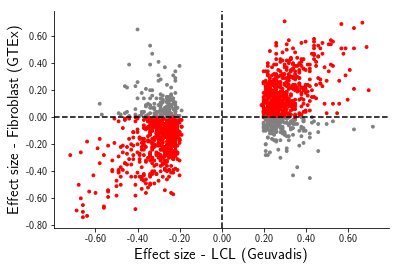

In [92]:
wbestr = data["Cells-Transformedfibroblasts"].copy()
merged = pd.merge(wbestr, NGESTR, on=["chrom","str.start","gene"])
merged = merged[merged["signif.estr"]]
merged["color"] = merged.apply(lambda x: ["gray","red"][np.sign(x["beta_x"])==np.sign(x["beta_y"])], 1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
merged = merged.round(2)
ax.scatter((merged["beta_y"]), merged["beta_x"], color=list(merged["color"]), s=8)
ax.grid(b=False)
ax.set_facecolor("white")
ax.axhline(y=0, color="black", linestyle="dashed")
ax.axvline(x=0, color="black", linestyle="dashed")
ax.set_xticklabels(["%.2f"%item for item in ax.get_xticks()], size=10)
ax.set_yticklabels(["%.2f"%item for item in ax.get_yticks()], size=10);
ax.set_xlabel("Effect size - LCL (Geuvadis)", size=15)
ax.set_ylabel("Effect size - Fibroblast (GTEx)", size=15);

print(str(scipy.stats.pearsonr(merged["beta_y"], merged["beta_x"])))
print(str(np.mean(merged["color"]=="red")))

if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "%s_effsize_inset.pdf"%FIGPREFIX))

# ANOVA + CAVIAR summary

In [2]:
# For each tissue:
#  - how many pass ANOVA at q<0.1?
#  - how many eSTR have highest caviar score?

perc_caviar = []
perc_anova_nom = []
perc_anova_fdr = []
for t in TISSUES:
    d = master[t]
    tissue_estrs = d[(d["best.str"]==1) & (d["qvalue"]<=MINQ)].copy()
    num_estrs = tissue_estrs.shape[0]
    num_best_caviar = tissue_estrs[tissue_estrs["top.variant"].apply(lambda x: "SNP_" not in x)].shape[0]
    num_anova_nom = tissue_estrs[tissue_estrs["anova_pval"]<MINANOVAP].shape[0]
    anova_p = list(tissue_estrs["anova_pval"])
    anova_p = [item for item in anova_p if not np.isnan(item)]
    rejected, anova_q = statsmodels.stats.multitest.fdrcorrection(list(anova_p))
    num_anova_fdr = len([item for item in anova_q if item < MINANOVAQ])
    print("%s numestrs=%s perccaviar=%.2f perc_anova=%.2f perc_anova_q=%s"%(t, num_estrs, \
                                                                            num_best_caviar*1.0/num_estrs, \
                                                                            num_anova_nom*1.0/num_estrs, \
                                                                           num_anova_fdr*1.0/num_estrs))
    perc_caviar.append(num_best_caviar*1.0/num_estrs)
    perc_anova_nom.append(num_anova_nom*1.0/num_estrs)
    perc_anova_fdr.append(num_anova_fdr*1.0/num_estrs)
    
print("\n")
print("Average percent best CAVIAR: %s"%np.mean(perc_caviar))
print("Average percent pass ANOVA p<%s: %s"%(MINANOVAP, np.mean(perc_anova_nom)))
print("Average percent pass ANOVA q<%s: %s"%(MINANOVAQ, np.mean(perc_anova_fdr)))

Artery-Aorta numestrs=2396 perccaviar=0.15 perc_anova=0.30 perc_anova_q=0.2474958263772955
Thyroid numestrs=4105 perccaviar=0.13 perc_anova=0.38 perc_anova_q=0.3412911084043849
Esophagus-Muscularis numestrs=2824 perccaviar=0.15 perc_anova=0.35 perc_anova_q=0.29992917847025496
Muscle-Skeletal numestrs=3370 perccaviar=0.13 perc_anova=0.36 perc_anova_q=0.3195845697329377
Lung numestrs=2989 perccaviar=0.14 perc_anova=0.34 perc_anova_q=0.28705252592840413
Brain-Caudate numestrs=675 perccaviar=0.20 perc_anova=0.25 perc_anova_q=0.15259259259259259
Esophagus-Mucosa numestrs=3461 perccaviar=0.13 perc_anova=0.34 perc_anova_q=0.29529037850332274
Cells-Transformedfibroblasts numestrs=3088 perccaviar=0.13 perc_anova=0.34 perc_anova_q=0.280440414507772
Adipose-Subcutaneous numestrs=3587 perccaviar=0.13 perc_anova=0.34 perc_anova_q=0.30387510454418737
Nerve-Tibial numestrs=4352 perccaviar=0.12 perc_anova=0.38 perc_anova_q=0.3435202205882353
Artery-Tibial numestrs=3454 perccaviar=0.13 perc_anova=0.35 

In [6]:
# Get list of all causal

chroms = []
starts = []
tissues = []
genes = []
genenames = []
scores = []
betas = []
pvals = []
qvals = []

# Keep track of LCL reproducibility
t1_data = master["LCL"]
prs = []
dirs = []

def IsCausal(x):
    return (x["caviar.score"])>=MIN_CAUSAL_SCORE
    
for t in TISSUES:
    d = master[t]
    tissue_estrs = d[(d["best.str"]==1) & (d["qvalue"]<=MINQ) ].copy()
    tissue_causal = tissue_estrs[tissue_estrs.apply(IsCausal, 1)].copy()
    chroms.extend(list(tissue_estrs["chrom_x"]))
    starts.extend(list(tissue_estrs["str.start"]))
    tissues.extend([t]*tissue_estrs.shape[0])
    genes.extend(list(tissue_estrs["gene"]))
    genenames.extend(list(tissue_estrs["gene.name"]))
    scores.extend(list(tissue_estrs["caviar.score"]))
    betas.extend(list(tissue_estrs["beta"]))
    pvals.extend(list(tissue_estrs["p.wald_x"]))
    qvals.extend(list(tissue_estrs["qvalue"]))
    print("%s %s"%(t, tissue_causal.shape[0]))
    
    d = pd.merge(t1_data[["str.id","gene","beta","significant"]], \
                     tissue_causal[["str.id","gene","beta","significant"]], on=["str.id","gene"])
    d = d[(d["significant_x"]) | (d["significant_y"])]
    x = scipy.stats.pearsonr(d["beta_x"], d["beta_y"])
    dsame = np.mean(np.sign(d["beta_x"])==np.sign(d["beta_y"]))
    #print("%s %s %s %s"%("LCL", t, x, dsame))
    prs.append(x[0])
    dirs.append(dsame)

print("Average pearson r with LCL: %s"%np.mean(prs))
print("Percent same direction: %s"%np.mean(dirs))

all_causal = pd.DataFrame({
    "chrom": chroms,
    "str.start": starts,
    "gene": genes,
    "gene.name": genenames,
    "score": scores,
    "beta": betas,
    "tissue": tissues,
    "pval": pvals,
    "qval": qvals
})

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

all_causal["tissue_info"] = all_causal.apply(lambda x: "%s_%.2f_%.2f"%(x["tissue"], x["beta"], x["score"]), 1)
all_causal["num.e"] = 1
all_unique_causal = all_causal.groupby(["chrom","str.start","gene","gene.name"], as_index=False).agg({"tissue_info": concat,
                                                                                              "score": max,
                                                                                                    "beta": maxabs,
                                                                                                     "pval": min,
                                                                                                     "qval": min,
                                                                                                     "num.e": sum})
all_unique_causal["causal"] = (all_unique_causal["score"]>=MIN_CAUSAL_SCORE)

# Number unique causal
print("Number total causal eSTRs: %s"%all_unique_causal[all_unique_causal["causal"]].shape[0])
print("Number total causal genes: %s"%len(set(all_unique_causal[all_unique_causal["causal"]]["gene"])))

# Add strand and motif info
hipmotif = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","period","motif_pos","motif_neg"])
hipmotif["str.start"] = hipmotif["str.start"]+1
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
geneannot["tss"] = geneannot.apply(lambda x: [x["gene.stop"],x["gene.start"]][x["gene.strand"]=="+"], 1)

all_unique_causal = pd.merge(all_unique_causal, hipmotif[["chrom","str.start","str.end","motif_pos","motif_neg"]], \
                            on=["chrom","str.start"])
all_unique_causal = pd.merge(all_unique_causal, geneannot[["gene","gene.strand","tss"]], on=["gene"])
all_unique_causal["motif"] = all_unique_causal.apply(lambda x: x["motif_pos"] if x["gene.strand"]=="+" else x["motif_neg"], 1)
all_unique_causal["dist.tss"] = all_unique_causal.apply(lambda x: (x["str.start"]-x["tss"]) if x["gene.strand"]=="+" else (x["tss"]-x["str.end"]), 1)

# Save supp table 2
all_unique_causal = all_unique_causal[["chrom","str.start","str.end","gene","gene.name","dist.tss","motif","score","beta","pval","qval","num.e","causal","tissue_info"]].sort_values("score", ascending=False)
all_unique_causal.to_csv(os.path.join(RESULTSDIR, "SuppTable_ALLCAUSAL.csv"))

Brain-Caudate 103
Muscle-Skeletal 272
Cells-Transformedfibroblasts 248
Nerve-Tibial 312
Skin-NotSunExposed 200
Heart-LeftVentricle 212
Esophagus-Mucosa 286
Thyroid 330
Adipose-Visceral 175
Esophagus-Muscularis 256
Adipose-Subcutaneous 292
Artery-Tibial 269
Lung 277
Skin-SunExposed 298
WholeBlood 206
Brain-Cerebellum 191
Artery-Aorta 234
Average pearson r with LCL: 0.4829151964490754
Percent same direction: 0.6546872404829479
Number total causal eSTRs: 3474
Number total causal genes: 3046
